# Predict Future Sales
##### Final project for "How to win a data science competition" Coursera course

##### In this playground competition, we will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

##### We are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

File descriptions : 
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

Data fields :
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, -February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category




In [153]:
# Libraries 
import pandas as pd
import numpy as np
#Viz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#Time Serie
import statsmodels.api as sm #to plot the decomposed time series
from pandas.plotting import lag_plot #Autocorrelation
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import adfuller # Stationarity

# Database

In [64]:
# shops.csv- supplemental information about the shops.
shops = pd.read_csv('shops.csv')
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [149]:
# items.csv - supplemental information about the items/products.
items = pd.read_csv('items.csv')
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [47]:
# item_categories.csv  - supplemental information about the items categories.
item_categories = pd.read_csv('item_categories.csv')
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [232]:
# sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
sales_train = pd.read_csv('sales_train.csv')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [507]:
# test.csv - the test set. We need to forecast the sales for these shops and products 
# for November 2015.
test = pd.read_csv('test.csv')
#test = test.set_index('ID')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# Data cleaning 

In [233]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [116]:
sales_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [117]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,214200.0,107099.500000,61834.358168,0.0,53549.75,107099.5,160649.25,214199.0
shop_id,214200.0,31.642857,17.561933,2.0,16.00,34.5,47.00,59.0
item_id,214200.0,11019.398627,6252.644590,30.0,5381.50,11203.0,16071.50,22167.0


In [234]:
# First I need to convert the date column from sales_train base to date type
sales_train.date = pd.to_datetime(sales_train.date)

In [637]:
import datetime as dt
sales_train['mon_year'] = pd.to_datetime(sales_train['date']).dt.to_period('M')
sales_train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,mon_year
0,2013-02-01,0,59,22154,999.00,1.0,2013-02
1,2013-03-01,0,25,2552,899.00,1.0,2013-03
2,2013-05-01,0,25,2552,899.00,-1.0,2013-05
3,2013-06-01,0,25,2554,1709.05,1.0,2013-06
4,2013-01-15,0,25,2555,1099.00,1.0,2013-01
5,2013-10-01,0,25,2564,349.00,1.0,2013-10
6,2013-02-01,0,25,2565,549.00,1.0,2013-02
7,2013-04-01,0,25,2572,239.00,1.0,2013-04
8,2013-11-01,0,25,2572,299.00,1.0,2013-11
9,2013-03-01,0,25,2573,299.00,3.0,2013-03


# Analysis & Visualisation 

In [66]:
#How many shop do we have ? 
print('Sales_train : ',sales_train.shop_id.nunique(),' shops')
print('Test : ',test.shop_id.nunique(),' shops')
#and for items ?
print('Sales_train : ',sales_train.item_id.nunique(),' items')
print('Test : ',test.item_id.nunique(),' items')
#nomber of categories ?
print('Numbers of categories : ',items.item_category_id.nunique())

Sales_train :  60  shops
Test :  42  shops
Sales_train :  21807  items
Test :  5100  items
Numbers of categories :  84


In [183]:
# I need the information (min,max,mean,sum) for each shop for each month  
monthly_sales=sales_train.groupby(["mon_year","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg(
    {"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})


In [214]:
monthly_sales.head(15)

date            item_price item_cnt_day
                                min        max       mean          sum
mon_year shop_id item_id                                              
2013-01  0       32      2013-01-21 2013-01-31      221.0          4.0
                 33      2013-01-17 2013-01-28      347.0          2.0
                 35      2013-01-02 2013-01-31      247.0          2.0
                 43      2013-01-31 2013-01-31      221.0          1.0
                 51      2013-01-13 2013-01-31      128.5          2.0
                 75      2013-01-17 2013-01-17       76.0          1.0
                 88      2013-01-16 2013-01-16       76.0          1.0
                 98      2013-01-13 2013-01-31      268.0         13.0
                 111     2013-01-17 2013-01-17       89.0          1.0
                 149     2013-01-17 2013-01-28       99.0          2.0
                 151     2013-01-16 2013-01-16       75.0          1.0
                 210     2013-01-25 2013-01-25      118.0          1.0
                 306     2013-01-22 2013-01-22       59.0          1.0
                 351     2013-01-21 2013-01-21       89.0          1.0
                 438     2013-01-31 2013-01-31      162.0          1.0

##### The objective is to predict sales for the next month at a store-item combination.

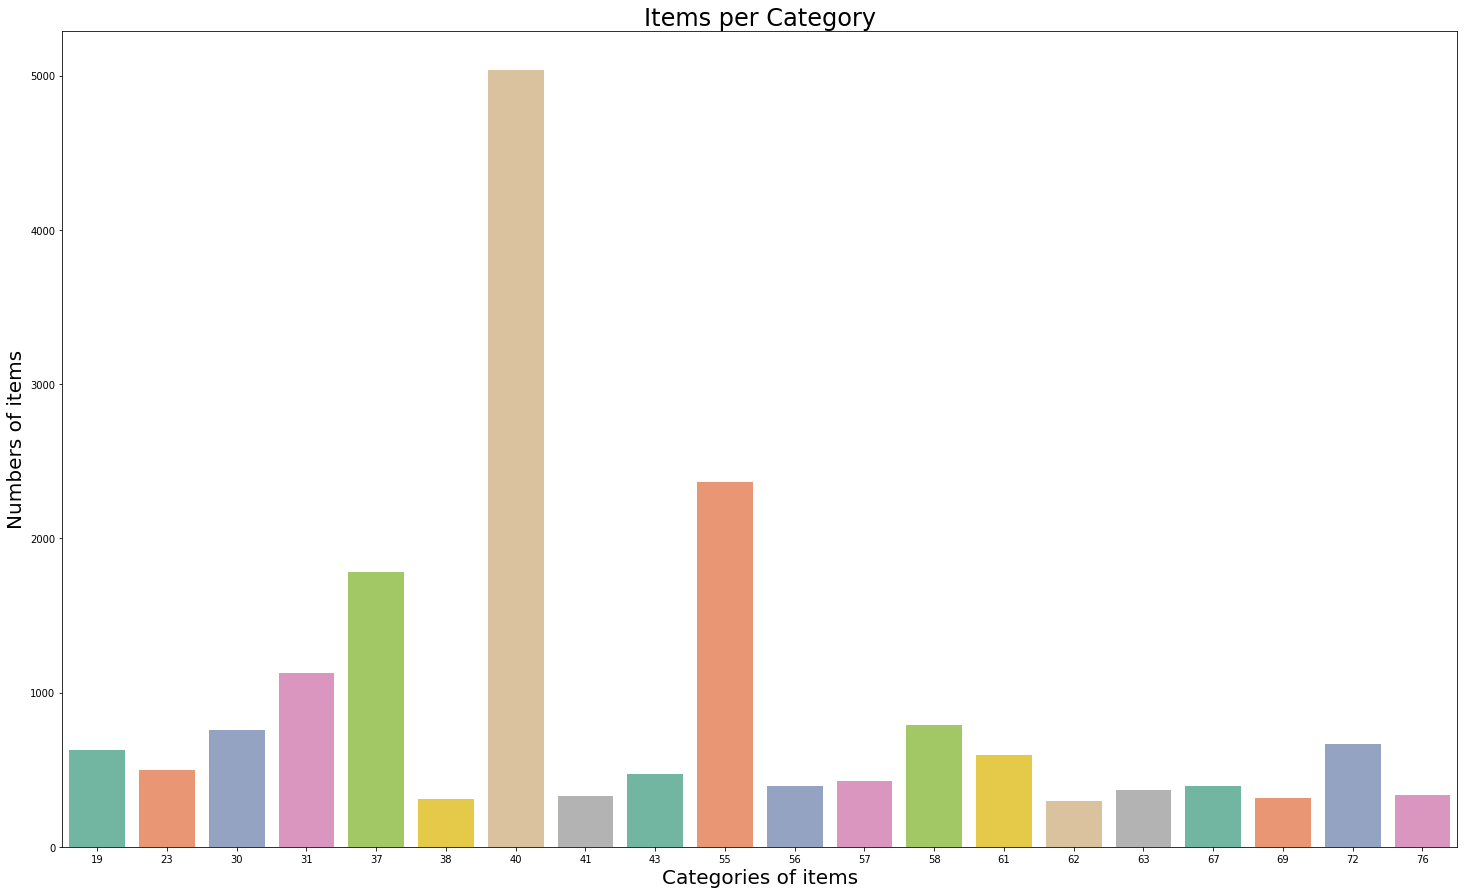

In [677]:
# number of items per cat 
x=items.groupby(['item_category_id']).count().sort_values(by='item_id',ascending=False)
x=x.iloc[0:20].reset_index()
# plot
plt.figure(figsize=(25,15))
ax= sns.barplot(x.item_category_id, x.item_id,palette='Set2')
plt.title("Items per Category",fontsize=24)
plt.ylabel('Numbers of items', fontsize=20)
plt.xlabel('Categories of items', fontsize=20)
plt.show()

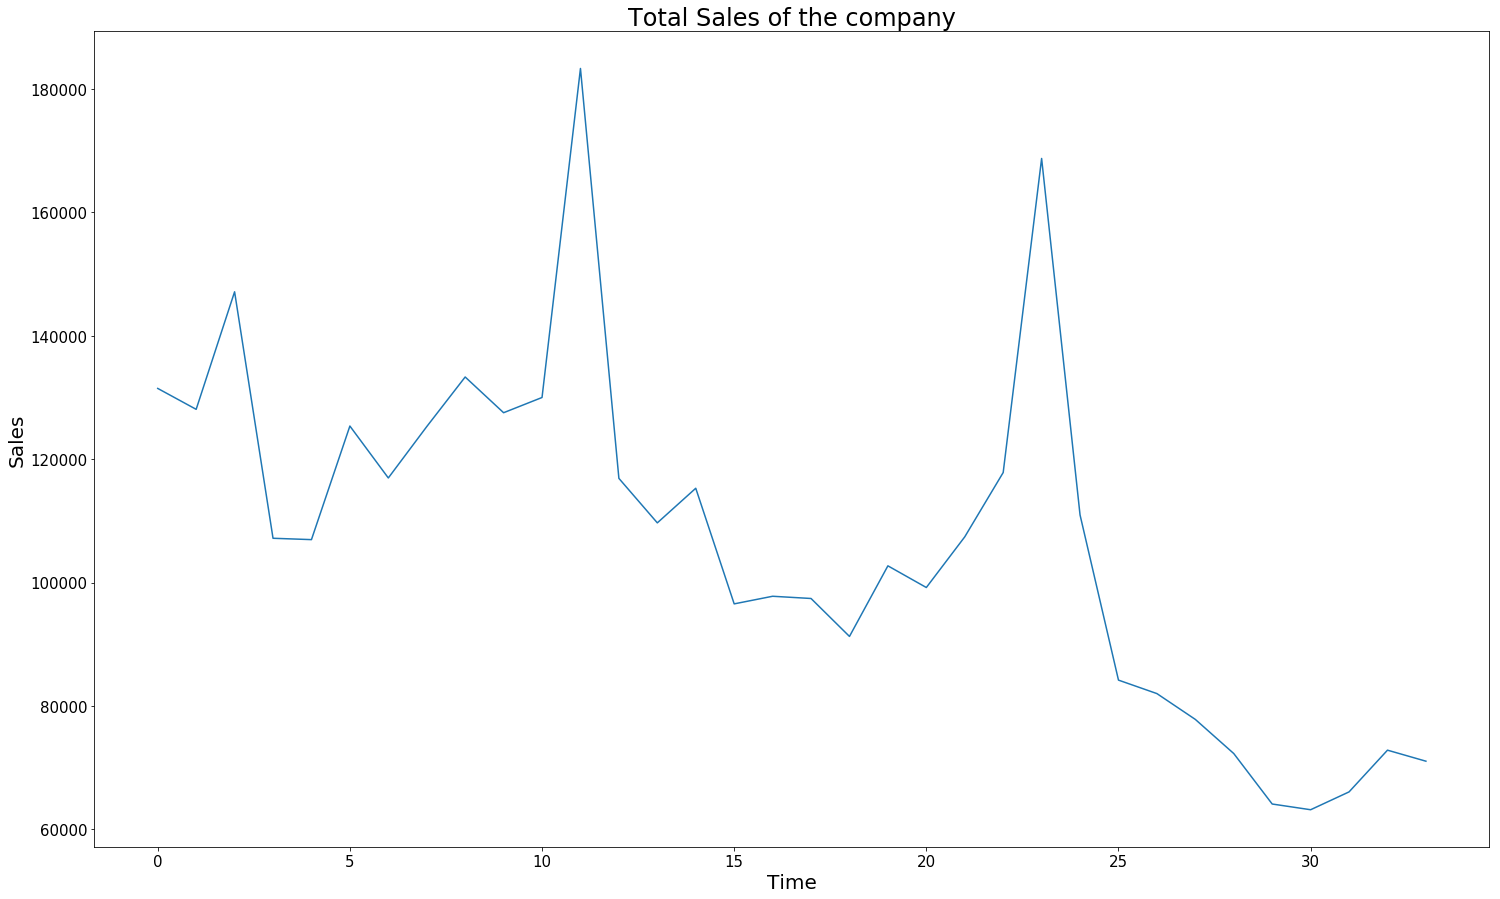

In [236]:
# Sales per month(January 2013 is 0 to October 2015 is 33)
plt.figure(figsize=(25,15))
date_sales=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum().astype('float')
plt.title('Total Sales of the company',fontsize=24)
plt.xlabel('Time',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Sales',fontsize=20)
plt.yticks(fontsize=15)
plt.plot(date_sales)
plt.show()
# unexpected increase sales during November 2013(11) and November 2014
# but in general, there is a decrease in sales 

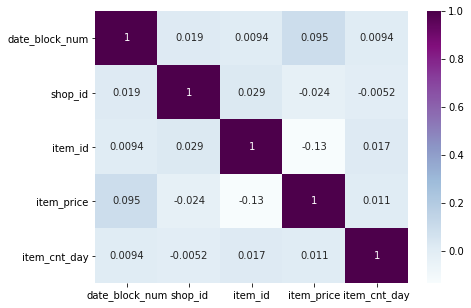

In [114]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(sales_train.corr(),cmap="BuPu",annot=True)
plt.show()

# Time Series

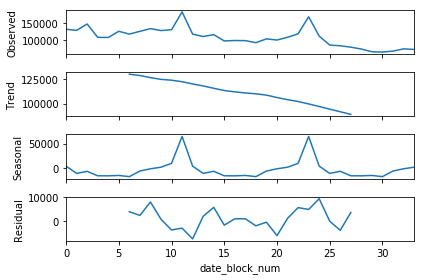

In [194]:
date_sales=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum().astype('float')
#12 months
res = sm.tsa.seasonal_decompose(date_sales,freq=12,model="additive")
resplot = res.plot()
#it seems that there is a seasonality as seen previously

## Stationarity

In [195]:
# the time serie is it stationarity ? (if its mean and variance do not vary over time)
#H 0: The data is not stationary
#H 1: The data is stationary

result = adfuller(date_sales)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
# With a p-value of .14%  I do not reject the null hypothesis,
# And conclude that the data is not stationary.

ADF Statistic: -2.395704
p-value: 0.142953
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


## Checking for Autocorrelation (AR)

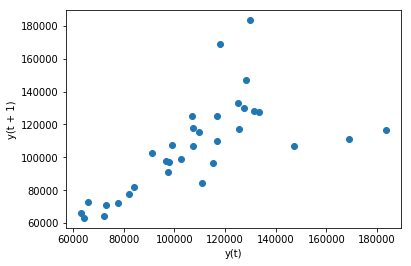

In [215]:
#I can check for autocorrelation in the data using a lag plot.
#AR(1) is a first-order autoregression model.
lag_plot(date_sales)
plt.show()
#A "line" along the diagonal shows that there is an autoregressive relationship.
#The series is explained by its past values rather than by other variables.

In [647]:
train,test=date_sales[:-20],date_sales[-20:]

In [648]:
model = AR(date_sales) # AR = Auto Regressive Model
model_fit = model.fit(maxlag = 12)
predictions = model_fit.predict(start = len(train), end = len(train) + len(test)-1,
                               dynamic = False)
model_fit.params

/Users/Eleonore/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


const               28.609080
L1.item_cnt_day      0.105089
L2.item_cnt_day      0.060844
L3.item_cnt_day      0.238195
L4.item_cnt_day      0.067365
L5.item_cnt_day     -0.021128
L6.item_cnt_day      0.103667
L7.item_cnt_day     -0.005930
L8.item_cnt_day     -0.005341
L9.item_cnt_day     -0.003341
L10.item_cnt_day     0.038638
L11.item_cnt_day     0.035188
L12.item_cnt_day     0.016314
dtype: float64

In [649]:
predictions2 = model_fit.predict(start = len(train), end = len(train) + len(test)-1,
                               dynamic = False)
predictions2

date        shop_id
2015-12-10  35         57.156080
            37         85.595425
            38         46.861452
            39         44.615498
            41         50.788884
            42         40.384477
            44         55.511905
            45         47.231236
            46         71.541438
            47         50.857556
            48         38.128754
            49         51.798848
            50         37.618637
            52         34.936584
            53         39.699911
            55         45.629299
            56         52.612656
            57         51.016309
            58         49.553406
            59         45.743789
dtype: float64

In [650]:
comparison = pd.DataFrame({'observed':test, 'predicted':round(predictions2,1)})
comparison

observed  predicted
date       shop_id                     
2015-12-10 35           30.0       57.2
           37            8.0       85.6
           38           16.0       46.9
           39           14.0       44.6
           41           12.0       50.8
           42          128.0       40.4
           44           12.0       55.5
           45           14.0       47.2
           46           25.0       71.5
           47           17.0       50.9
           48            9.0       38.1
           49           12.0       51.8
           50            9.0       37.6
           52           40.0       34.9
           53           45.0       39.7
           55           53.0       45.6
           56           18.0       52.6
           57           25.0       51.0
           58           28.0       49.6
           59           22.0       45.7

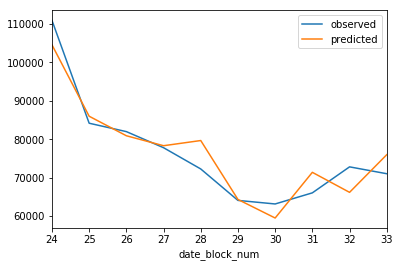

In [167]:
comparison.plot()

## ARMA

In [664]:
from statsmodels.tsa.arima_model import ARMA
# fit model
model = ARMA(date_sales, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(date_sales), len(date_sales))
print(yhat)

/Users/Eleonore/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


47228    41.478119
dtype: float64


/Users/Eleonore/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


## ARIMA 

# Prophet method

In [226]:
from fbprophet import Prophet

In [421]:
date_sales=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum() 
date_sales.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
date_sales=date_sales.reset_index()
date_sales.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [422]:
#The input to Prophet is always a dataframe with two columns: ds and y. 
#The ds (datestamp) column should be of a date format. 
#The y column must be numeric, and represents the measurement we wish to forecast.
date_sales.columns=['ds','y'] 

In [401]:
date_sales['y_orig'] = date_sales['y'] # to save a copy of the original data. 
# log-transform y
date_sales['y'] = np.log(date_sales['y'])

In [403]:
model = Prophet() #instantiate Prophet
model.fit(date_sales); #fit the model with my dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Eleonore/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [405]:
future_data = model.make_future_dataframe(periods=6, freq = 'm')
forecast_data = model.predict(future_data)

In [406]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
35,2015-11-30,11.667338,11.582006,11.752659
36,2015-12-31,11.603647,11.438055,11.775720
37,2016-01-31,10.529376,10.273912,10.807543
38,2016-02-29,10.796784,10.446767,11.200750
39,2016-03-31,10.930448,10.453180,11.482859


In [652]:
model.plot(forecast_data)

AttributeError: 'AR' object has no attribute 'plot'

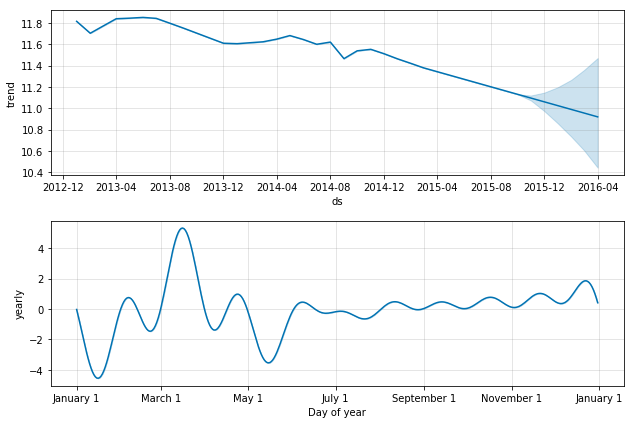

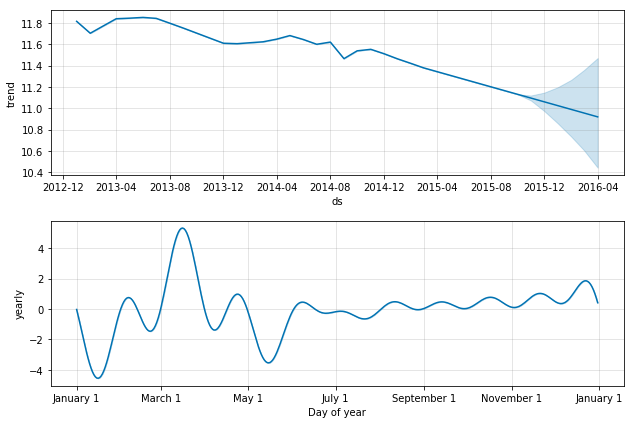

In [408]:
model.plot_components(forecast_data)

In [409]:
forecast_data_orig = forecast_data # make sure we save the original forecast data
forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])

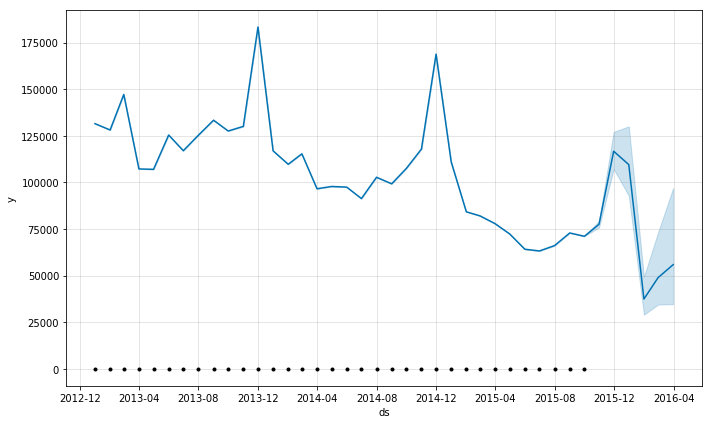

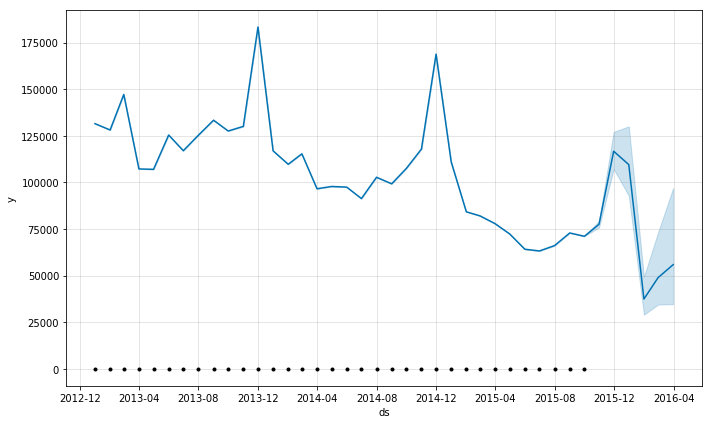

In [410]:
model.plot(forecast_data_orig)

# Prophet (5 time series)

In [272]:
forecast_data

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,11.816234,131478.999998,131479.000002,11.816234,11.816234,-0.029631,-0.029631,-0.029631,-0.029631,-0.029631,-0.029631,0.0,0.0,0.0,131479.000000
1,2013-02-01,11.704292,128089.999998,128090.000002,11.704292,11.704292,0.056196,0.056196,0.056196,0.056196,0.056196,0.056196,0.0,0.0,0.0,128090.000000
2,2013-03-01,11.769185,147141.999998,147142.000002,11.769185,11.769185,0.129969,0.129969,0.129969,0.129969,0.129969,0.129969,0.0,0.0,0.0,147142.000000
3,2013-04-01,11.840544,107189.999998,107190.000002,11.840544,11.840544,-0.258186,-0.258186,-0.258186,-0.258186,-0.258186,-0.258186,0.0,0.0,0.0,107190.000000
4,2013-05-01,11.845690,106969.999998,106970.000002,11.845690,11.845690,-0.265386,-0.265386,-0.265386,-0.265386,-0.265386,-0.265386,0.0,0.0,0.0,106970.000000
5,2013-06-01,11.852951,125380.999998,125381.000002,11.852951,11.852951,-0.113838,-0.113838,-0.113838,-0.113838,-0.113838,-0.113838,0.0,0.0,0.0,125381.000000
6,2013-07-01,11.844016,116965.999998,116966.000002,11.844016,11.844016,-0.174377,-0.174377,-0.174377,-0.174377,-0.174377,-0.174377,0.0,0.0,0.0,116966.000000
7,2013-08-01,11.798505,125290.999998,125291.000002,11.798505,11.798505,-0.060110,-0.060110,-0.060110,-0.060110,-0.060110,-0.060110,0.0,0.0,0.0,125291.000000
8,2013-09-01,11.752186,133331.999998,133332.000002,11.752186,11.752186,0.048412,0.048412,0.048412,0.048412,0.048412,0.048412,0.0,0.0,0.0,133332.000000
9,2013-10-01,11.705390,127540.999998,127541.000002,11.705390,11.705390,0.050804,0.050804,0.050804,0.050804,0.050804,0.050804,0.0,0.0,0.0,127541.000000


I used Prophet method to predict the total sales, but now I need to predict the total sales for each shop. To do that I need to calculate the total of items.
Three points to consider :
- Not all stores sell all items
- What happens when a new product is introduced?
- What if a product is removed off the shelves?


In [273]:
#How many shop do we have ? 
print('Sales_train : ',sales_train.shop_id.nunique(),' shops')
print('Test : ',test.shop_id.nunique(),' shops')
#and for items ?
print('Sales_train : ',sales_train.item_id.nunique(),' items')
print('Test : ',test.item_id.nunique(),' items')
#nomber of categories ?
print('Numbers of categories : ',items.item_category_id.nunique())

Sales_train :  60  shops
Test :  42  shops
Sales_train :  21807  items
Test :  5100  items
Numbers of categories :  84


So we have 60 shops and 21807 items

In [274]:
date_sales=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
date_sales.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
date_sales=date_sales.reset_index()
date_sales.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [275]:
monthly_sales=sales_train.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum()

In [280]:
monthly_sales=monthly_sales.unstack(level=-1).fillna(0) 
monthly_sales=monthly_sales.T
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')

In [499]:
monthly_sales.index=dates
monthly_sales=monthly_sales.reset_index()
monthly_sales.head()

ValueError: cannot insert ('level_0', ''), already exists

In [657]:
monthly_shop_sales=sales_train.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
# get the shops to the columns
monthly_shop_sales=monthly_shop_sales.unstack(level=1)
monthly_shop_sales=monthly_shop_sales.fillna(0)
monthly_shop_sales.index=dates
monthly_shop_sales=monthly_shop_sales.reset_index()
monthly_shop_sales.head()

shop_id,index,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,2013-01-01,5578.0,2947.0,1146.0,767.0,2114.0,0.0,3686.0,2495.0,1463.0,...,3406.0,2748.0,1812.0,2055.0,9386.0,0.0,3238.0,0.0,0.0,2017.0
1,2013-02-01,6127.0,3364.0,488.0,798.0,2025.0,877.0,4007.0,2513.0,1156.0,...,3054.0,2284.0,1737.0,1906.0,8075.0,0.0,2655.0,0.0,0.0,1897.0
2,2013-03-01,0.0,0.0,753.0,959.0,2060.0,1355.0,4519.0,2460.0,977.0,...,3610.0,2605.0,2034.0,2365.0,9488.0,0.0,3099.0,6586.0,3773.0,2028.0
3,2013-04-01,0.0,0.0,583.0,647.0,285.0,1008.0,3168.0,1540.0,-1.0,...,2740.0,1945.0,1446.0,1515.0,6726.0,0.0,2153.0,5493.0,2831.0,1388.0
4,2013-05-01,0.0,0.0,553.0,710.0,1211.0,1110.0,3022.0,1647.0,0.0,...,2839.0,2243.0,1482.0,1767.0,7006.0,852.0,2140.0,5233.0,2308.0,1374.0


In [496]:
monthly_shop_sales = monthly_shop_sales.append(monthly_shop_sales.sum(numeric_only=True), ignore_index=True)

In [501]:
# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_shop_sales)):
    #take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:, node+1]], axis = 1)
    #print(nodeToForecast.head())  #to check
    #rename for prophet compatability
    for i in range(1,60):
        nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
        nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[i] : 'y'})
    #nodeToForecast = nodeToForecast.drop([34])
    #growth = 'linear'
        model = Prophet(yearly_seasonality=True)
        model.fit(nodeToForecast)
        forecast = model.make_future_dataframe(periods = 1, freq = 'MS')
        forecastsDict[node] = model.predict(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Eleonore/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


IndexError: index 2 is out of bounds for axis 0 with size 2

In [491]:
forecastsDict[node]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,-1.779309,-217.055727,385.713365,-1.779309,-1.779309,79.251652,79.251652,79.251652,79.251652,79.251652,79.251652,0.0,0.0,0.0,77.472343
1,2013-02-01,11.760899,-216.217019,384.580000,11.760899,11.760899,85.393304,85.393304,85.393304,85.393304,85.393304,85.393304,0.0,0.0,0.0,97.154203
2,2013-03-01,23.990764,-295.871989,350.728123,23.990764,23.990764,8.354429,8.354429,8.354429,8.354429,8.354429,8.354429,0.0,0.0,0.0,32.345193
3,2013-04-01,37.530972,-370.711730,282.347837,37.530972,37.530972,-79.855666,-79.855666,-79.855666,-79.855666,-79.855666,-79.855666,0.0,0.0,0.0,-42.324693
4,2013-05-01,50.634399,-469.073524,124.887005,50.634399,50.634399,-210.170971,-210.170971,-210.170971,-210.170971,-210.170971,-210.170971,0.0,0.0,0.0,-159.536572
5,2013-06-01,64.174607,-528.811727,58.686655,64.174607,64.174607,-297.275089,-297.275089,-297.275089,-297.275089,-297.275089,-297.275089,0.0,0.0,0.0,-233.100482
6,2013-07-01,77.278034,-529.388516,84.688369,77.278034,77.278034,-321.177754,-321.177754,-321.177754,-321.177754,-321.177754,-321.177754,0.0,0.0,0.0,-243.899720
7,2013-08-01,90.818241,-441.173871,148.550139,90.818241,90.818241,-239.629219,-239.629219,-239.629219,-239.629219,-239.629219,-239.629219,0.0,0.0,0.0,-148.810978
8,2013-09-01,104.358449,-199.841273,414.620752,104.358449,104.358449,-11.930885,-11.930885,-11.930885,-11.930885,-11.930885,-11.930885,0.0,0.0,0.0,92.427564
9,2013-10-01,117.461876,-101.371563,509.207257,117.461876,117.461876,96.871892,96.871892,96.871892,96.871892,96.871892,96.871892,0.0,0.0,0.0,214.333768


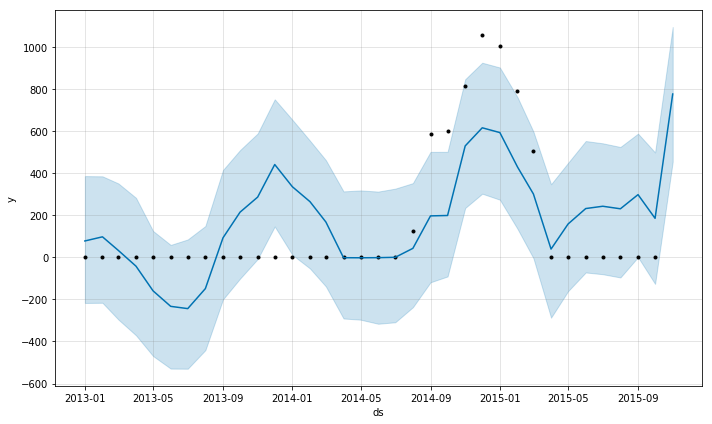

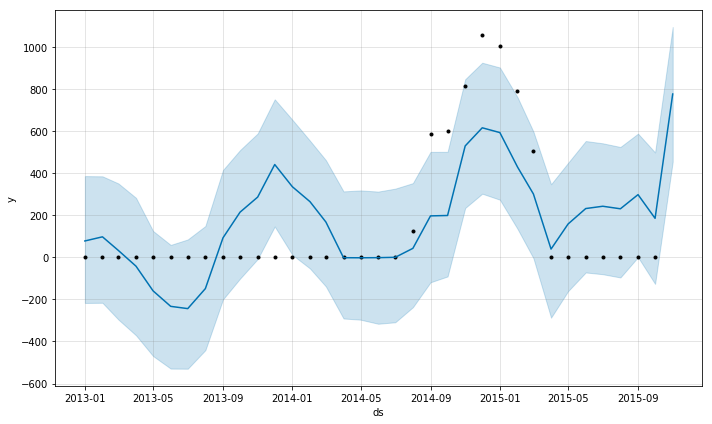

In [492]:
model.plot(forecastsDict[node])

In [317]:
total_shop = pd.DataFrame(monthly_shop_sales.iloc[34])

In [340]:
total_shop.nlargest(5,'total_sales')

,shop_id,total_sales
60,59,59.0
59,58,58.0
58,57,57.0
57,56,56.0
56,55,55.0


In [330]:
total_shop = total_shop.reset_index()

In [333]:
total_shop.columns = ['shop_id', 'total_sales']

In [339]:
total_shop.dtypes

shop_id         object
total_sales    float64
dtype: object

In [338]:
total_shop.total_sales = total_shop.apply(pd.to_numeric, errors='coerce')

In [654]:
test = monthly_shop_sales.describe().T

In [655]:
test.nlargest(5,'min')

,count,mean,std,min,25%,50%,75%,max
shop_id,,,,,,,,
31,34.0,9140.500000,2401.995550,5714.0,7356.75,9160.0,10058.25,16318.0
25,34.0,7115.294118,1787.511840,4675.0,5956.00,6648.5,7917.25,12257.0
42,34.0,4262.764706,833.919335,3501.0,3777.00,4014.5,4435.25,7256.0
28,34.0,5428.147059,1430.675897,2979.0,4276.25,5495.0,6749.50,8499.0
21,34.0,2016.470588,495.489304,1495.0,1826.25,1898.5,2059.00,3959.0


In [357]:
test_shop = pd.DataFrame(monthly_shop_sales.iloc[[54,28,42,57,27]])

IndexError: single positional indexer is out-of-bounds

In [384]:
new = monthly_shop_sales[['index',31,25,42,28,6]].copy()
new = new.drop([34])
new

shop_id,index,31,25,42,28,6
0,2013-01-01,10173.0,8215.0,3991.0,7057.0,3686.0
1,2013-02-01,11160.0,7934.0,3965.0,5438.0,4007.0
2,2013-03-01,12670.0,9732.0,4953.0,6918.0,4519.0
3,2013-04-01,9621.0,7867.0,3978.0,4910.0,3168.0
4,2013-05-01,9423.0,6860.0,3594.0,5703.0,3022.0
5,2013-06-01,10072.0,8478.0,4349.0,7056.0,3847.0
6,2013-07-01,9500.0,7361.0,3801.0,6739.0,3360.0
7,2013-08-01,9882.0,7784.0,4035.0,7521.0,3702.0
8,2013-09-01,11204.0,9251.0,5093.0,6753.0,4208.0
9,2013-10-01,10754.0,8356.0,4464.0,5609.0,3675.0


In [397]:
new.columns = new.columns.astype(str)
new.columns = new.columns.str.replace('index','date').str.replace(
    '31','shop1').str.replace('25','shop2').str.replace('42','shop3').str.replace(
    '28','shop4').str.replace('6','shop5')

In [398]:
new.columns

Index(['date', 'shop1', 'shop2', 'shop3', 'shop4', 'shop5'], dtype='object', name='shop_id')

Next step = try prophet with each shop

## Loop

In [429]:
def run_prophet(timeserie):
    model = Prophet(yearly_seasonality=True,daily_seasonality=False)
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=6, freq = 'm',include_history=False)
    forecast = model.predict(forecast)
    return forecast

In [430]:
f = run_prophet(date_sales)
f

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/Users/Eleonore/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-10-31,68141.635142,96148.829366,102365.130051,68105.472235,68174.227246,31096.333941,31096.333941,31096.333941,31096.333941,31096.333941,31096.333941,0.0,0.0,0.0,99237.969083
1,2015-11-30,64885.535895,116221.600819,122427.901322,64757.515978,65003.434165,54349.090303,54349.090303,54349.090303,54349.090303,54349.090303,54349.090303,0.0,0.0,0.0,119234.626197
2,2015-12-31,61520.900006,102941.421800,109257.641457,61256.913137,61763.974641,44459.672028,44459.672028,44459.672028,44459.672028,44459.672028,44459.672028,0.0,0.0,0.0,105980.572034
3,2016-01-31,58156.264116,21464.491151,28083.089364,57727.896428,58548.025530,-33286.978517,-33286.978517,-33286.978517,-33286.978517,-33286.978517,-33286.978517,0.0,0.0,0.0,24869.285599
4,2016-02-29,55008.701510,26203.739136,32718.325945,54422.021321,55570.069930,-25574.786743,-25574.786743,-25574.786743,-25574.786743,-25574.786743,-25574.786743,0.0,0.0,0.0,29433.914767
5,2016-03-31,51644.065621,44132.399604,50707.779210,50863.113453,52420.023987,-3980.270874,-3980.270874,-3980.270874,-3980.270874,-3980.270874,-3980.270874,0.0,0.0,0.0,47663.794747


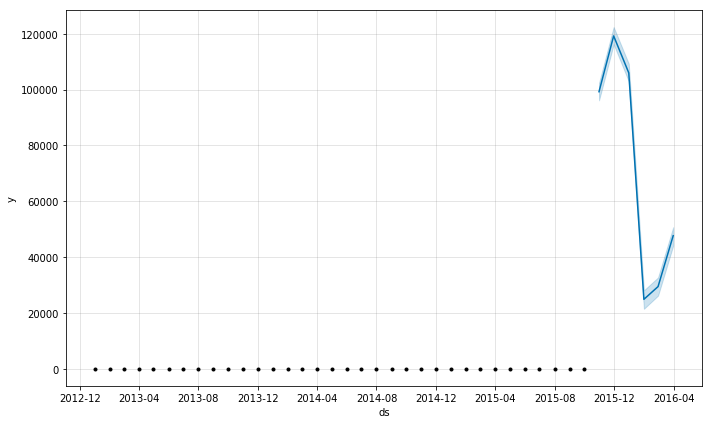

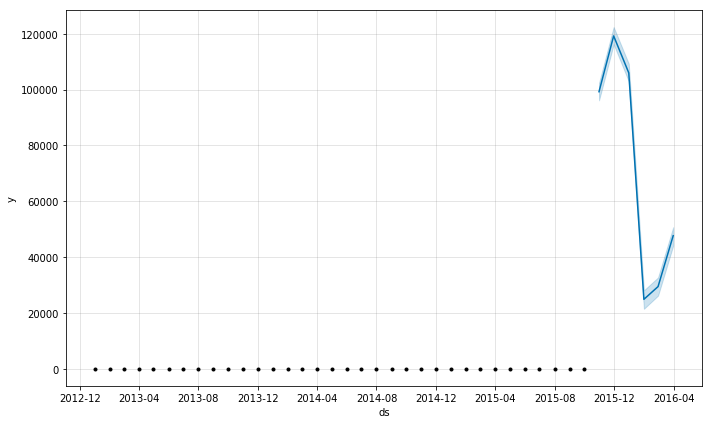

In [431]:
model.plot(f)

In [442]:
new_ppht = new.copy()

In [447]:
new_ppht.columns = new_ppht.columns.str.replace('date','ds').str.replace('shop1','y')

In [448]:
new_ppht.columns

Index(['ds', 'y', 'shop2', 'shop3', 'shop4', 'shop5'], dtype='object', name='shop_id')

In [450]:
t = run_prophet(new_ppht)
t

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/Users/Eleonore/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-10-31,6868.836604,8897.155309,9302.393184,6865.634892,6871.807959,2233.342586,2233.342586,2233.342586,2233.342586,2233.342586,2233.342586,0.0,0.0,0.0,9102.179189
1,2015-11-30,6715.276209,13412.000047,13837.882034,6703.457744,6725.573257,6905.287885,6905.287885,6905.287885,6905.287885,6905.287885,6905.287885,0.0,0.0,0.0,13620.564094
2,2015-12-31,6556.597135,10916.549618,11335.862162,6534.159539,6579.047451,4569.320007,4569.320007,4569.320007,4569.320007,4569.320007,4569.320007,0.0,0.0,0.0,11125.917142
3,2016-01-31,6397.918061,3407.304927,3837.360737,6362.072529,6433.081899,-2762.981851,-2762.981851,-2762.981851,-2762.981851,-2762.981851,-2762.981851,0.0,0.0,0.0,3634.936210
4,2016-02-29,6249.476346,3946.981670,4361.005753,6197.447539,6297.805168,-2087.550993,-2087.550993,-2087.550993,-2087.550993,-2087.550993,-2087.550993,0.0,0.0,0.0,4161.925354
5,2016-03-31,6090.797272,5920.763224,6373.105779,6022.288908,6157.110379,74.237540,74.237540,74.237540,74.237540,74.237540,74.237540,0.0,0.0,0.0,6165.034812


In [571]:
shop1 = new_ppht[['ds','y']]
shop2 = new_ppht[['ds','shop2']]
shop2.columns = shop2.columns.str.replace('shop2','y')
shop3 = new_ppht[['ds','shop3']]
shop3.columns = shop3.columns.str.replace('shop3','y')
shop4 = new_ppht[['ds','shop4']]
shop4.columns = shop4.columns.str.replace('shop4','y')
shop5 = new_ppht[['ds','shop5']]
shop5.columns = shop5.columns.str.replace('shop5','y')

In [545]:
dummy= sales_train.groupby(["shop_id"])
dummy

In [543]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-10-01,0,25,2564,349.00,1.0
6,2013-02-01,0,25,2565,549.00,1.0
7,2013-04-01,0,25,2572,239.00,1.0
8,2013-11-01,0,25,2572,299.00,1.0
9,2013-03-01,0,25,2573,299.00,3.0


# Start from the beginning !!! YEAAAAAAH
##### but with 1 shop...

In [573]:
shop1.head()

shop_id,ds,y
0,2013-01-01,10173.0
1,2013-02-01,11160.0
2,2013-03-01,12670.0
3,2013-04-01,9621.0
4,2013-05-01,9423.0


## Prophet

In [666]:
shop1.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
shop1.head()

shop_id,ds,y
2013-01-01,2013-01-01,10173.0
2013-02-01,2013-02-01,11160.0
2013-03-01,2013-03-01,12670.0
2013-04-01,2013-04-01,9621.0
2013-05-01,2013-05-01,9423.0


In [667]:
shop1['y_orig'] = shop1['y'] # to save a copy of the original data..you'll see why shortly. 
# log-transform y
shop1['y'] = np.log(shop1['y'])

/Users/Eleonore/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Eleonore/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [668]:
model = Prophet() #instantiate Prophet
model.fit(shop1); #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Eleonore/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [669]:
future_data = model.make_future_dataframe(periods=6, freq = 'm')
forecast_data = model.predict(future_data)

In [670]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
35,2015-11-30,9.652355,9.629716,9.676046
36,2015-12-31,9.090429,9.060666,9.120917
37,2016-01-31,8.366767,8.324510,8.409492
38,2016-02-29,8.512780,8.454955,8.567953
39,2016-03-31,8.706258,8.632853,8.776670


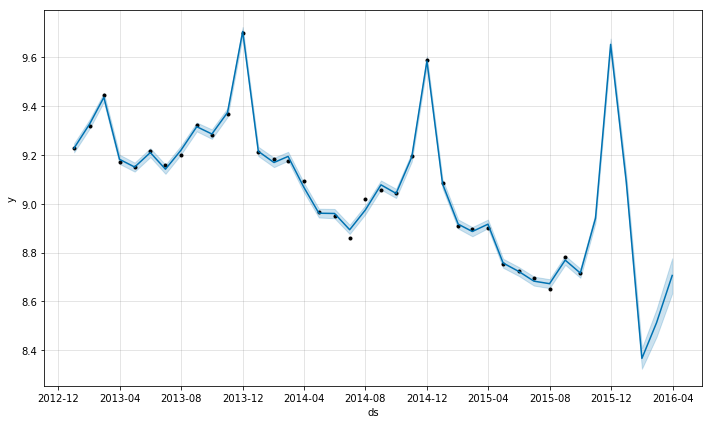

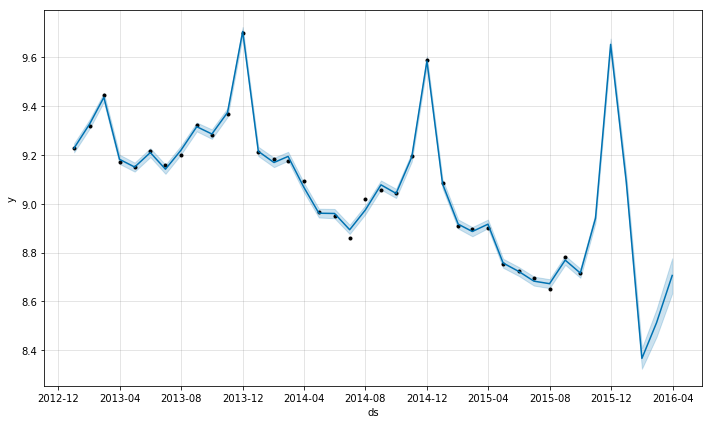

In [671]:
model.plot(forecast_data)

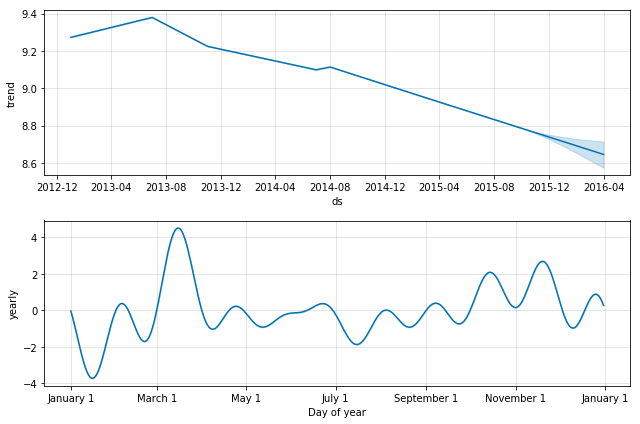

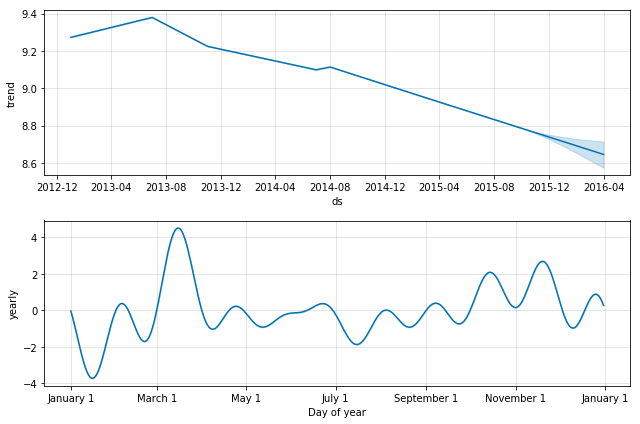

In [672]:
model.plot_components(forecast_data)

## SARIMAX

In [629]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model2 = SARIMAX(shopp1.set_index('ds'))
model2

/Users/Eleonore/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/Eleonore/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


In [630]:
model2_fit = model2.fit()

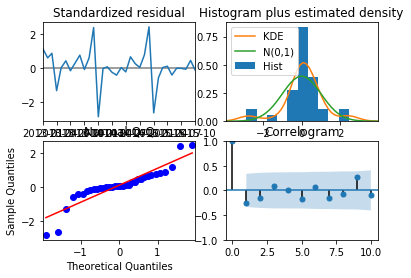

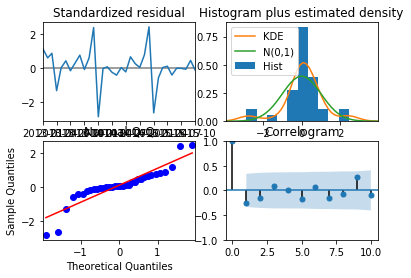

In [634]:
model2_fit.plot_diagnostics()

In [631]:
yhat = model2_fit.forecast()

/Users/Eleonore/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


/Users/Eleonore/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


TypeError: float() argument must be a string or a number, not 'Period'

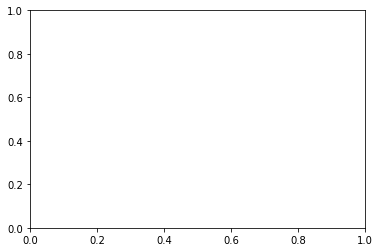

In [636]:
yhat = model2_fit.get_forecast(steps=3)
yhat.predicted_mean.plot()

In [633]:
model2.plot(yhat)

AttributeError: 'SARIMAX' object has no attribute 'plot'

In [628]:
shopp1.set_index('ds')

shop_id,y
ds,
2013-01-01,10173.0
2013-02-01,11160.0
2013-03-01,12670.0
2013-04-01,9621.0
2013-05-01,9423.0
2013-06-01,10072.0
2013-07-01,9500.0
2013-08-01,9882.0
2013-09-01,11204.0


In [607]:
cols = [0,1]
sh = shopp1[shopp1.columns[cols]]
sh.index.name = None

In [618]:
sh1 = sh.rename_axis(None)
sh2=sh1.reset_index(drop=True)
sh2.columns

Index(['ds', 'y'], dtype='object', name='shop_id')

In [660]:
import statsmodels.tsa.api as smt

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(shop1, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic:    inf | order: None
